# Creating spectrograms

In [140]:
import torch
from torch.utils import data
from torchaudio import datasets
import numpy as np
import os
from scipy.io import wavfile
from scipy import signal
from tqdm import tqdm

from torchaudio import transforms as tf_audio
from torchvision import transforms as tf_img
from torchvision.transforms import functional as fn
import torch.nn.functional as fn_t
import torch.nn as nn

import einops
import matplotlib.pyplot as plt
import librosa
import noisereduce as nr

trainPath = "../data/raw/train/bed/"

In [2]:
class TensorflowDataset:
    """
    Import paths of files
    """
    def __init__(self, directory : str, transforms, DEBUG : bool = False):
        self.directory = str
        self.paths = []
        self.labels = []
        self.background_noise_label = "_background_noise_"
        self.transforms = transforms

        for i, (root, dirs, files) in enumerate(os.walk(trainPath)):

            if files:
                label = os.path.normpath(root).split("\\")[-1]
                if label != self.background_noise_label:
                    for file in tqdm(files):
                        filepath = os.path.normpath(os.path.join(root, file))
                    
                        self.paths.append(filepath)
                        self.labels.append(label)

        if not DEBUG:
            assert len(np.unique(self.labels)) == 30

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        file_sr, file_data = wavfile.read(self.paths[idx])
        
        if self.transforms:
            return self.transforms(file_data)
        else:
            return file_data

In [3]:
class NoiseReducer:
    def __init__(self, sample_noise = None, sr=16000, **kwargs):
        self.sample_noise = sample_noise
        self.kwargs = kwargs
        self.sr = sr

    def __call__(self, data):
        if self.sample_noise:
            noise_sample = data[:int(self.sr * 0.5)]
        return nr.reduce_noise(y=data, y_noise = noise_sample if self.sample_noise else None, sr=self.sr, **self.kwargs)

class Resample:
    def __init__(self, sample_rate = 16000):
        self.sr = sample_rate
    def __call__(self, data):
        return librosa.resample(data.astype(float), orig_sr=len(data), target_sr = self.sr)

class ToFloatTensor:
    def __call__(self, data):
        return torch.from_numpy(data).float()

class HannWindow:
    def __call__(self, data):
        return signal.windows.hann(self.window_length)

In [36]:
SAMPLE_RATE = 16000

transforms = tf_img.Compose([
    NoiseReducer(sample_noise=True, sr=16000, stationary=True),
    Resample(sample_rate=16000),
    ToFloatTensor(),
    tf_audio.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=50, n_fft=358),
])


trainset = TensorflowDataset(trainPath, transforms=transforms, DEBUG=True)
trainloader = data.DataLoader(trainset, batch_size=6)

100%|██████████| 1713/1713 [00:00<00:00, 450234.54it/s]


In [ ]:
def display_spectrogram(spec : torch.tensor):
    fig, ax = plt.subplots()
    spec_db = librosa.power_to_db(spec.numpy())
    ax.imshow(spec_db, origin="lower", aspect="auto", interpolation="nearest")
    plt.show()

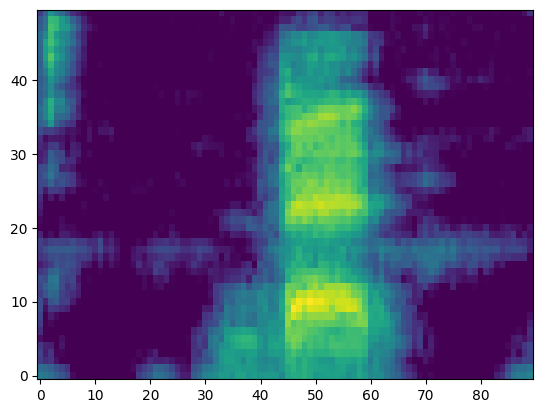

In [ ]:
A = next(iter(trainloader))

# Patch embeddings

In [61]:
class PatchEmbedding:
    """
    Takes as input image n by m.
    Outputs tensor (batch_qantity, num_of_patches, patch_x, patch_y)
    """

    def __init__(self, img_dim, patch_dim = (10,10)):
        self.img_dim = img_dim
        self.patch_dim = patch_dim

        assert img_dim[0] % patch_dim[0] == 0
        assert img_dim[1] % patch_dim[1] == 0
        
    def __call__(self, img):
        """
        assert img.dim() == 2 # for debuggin, later in batch change to 3

        patches = fn_t.unfold(img, kernel_size=self.patch_dim, stride=self.patch_dim)

        patches_r = img.shape[0] / self.patch_dim[0]
        patches_c = img.shape[1] / self.patch_dim[1]
        total_patches = patches_c * patches_r

        return patches.reshape(1, total_patches, 1, self.patch_dim[0], self.patch_dim[1])
        """
        patches = einops.rearrange(
        img, 
        '(h ph) (w pw) -> (h w) ph pw', 
        ph=self.patch_dim[0], pw=self.patch_dim[1]
        )
        return patches

In [70]:
pe = PatchEmbedding(img_dim=(50, 90), patch_dim=(25,45))

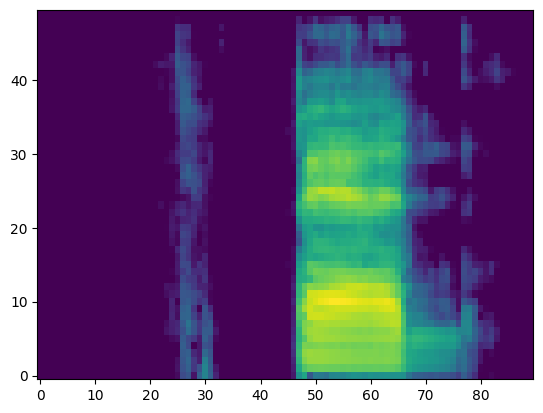

In [130]:
display_spectrogram(A[0])

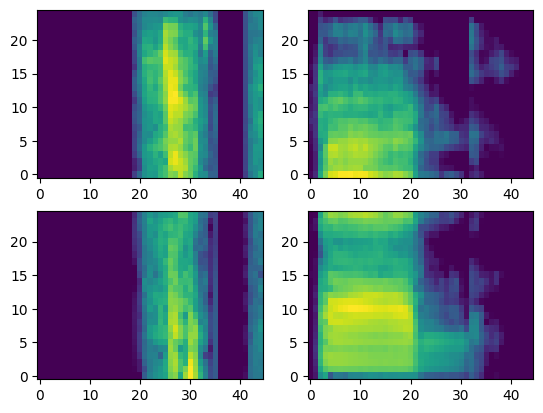

In [129]:
fig, axes = plt.subplots(2, 2)
r, c = 0, 0
for i, patch in enumerate(pe(A[0])):
    spec_db = librosa.power_to_db(patch.numpy())
    axes[1-r][c].imshow(spec_db, origin="lower", aspect="auto", interpolation="nearest")
    
    c += 1
    if c >= 2:
        c = 0
        r += 1
        
    if r >= 2:
        break

plt.show()

In [138]:
tensor = A[0]

In [139]:
tensor.flatten()

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.9854e+01, 5.4233e-08,
        0.0000e+00])

In [ ]:
def attention(Q, K, V):
    """
    Perform attention operation
    """
    d_k = Q.size(-1)
    out = torch.matmul(Q, K.transpose()) / torch.math.sqrt(d_k) # transpose arguments?
    out = torch.matmul(out.softmax(), V)
    return out



In [ ]:
class MultiHead(nn.Module):
    
    # Concat heads
    # Matmul W^O

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super.__init__()
        # layer normalization
        # MultiHead
        # residual connection
        # layer normalization
        # MLP
        # residual connection

    def forward(self, x):
        return x

In [ ]:
class LinearProjectionOfPatches(nn.Module):
    def __init__(self, dim_in, dim_out):
        super.__init__()

        self.L1 = nn.Linear(dim_in, dim_out)
        
    def forward(self, x):
        x = self.L1(x)
        return x

class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        img_dim=(50, 90)
        patch_dim=(10,10)
        Lin1Dim = 128

        self.PE = PatchEmbedding(img_dim=img_dim, patch_dim=patch_dim)
        self.PELin = LinearProjectionOfPatches(img_dim[0] * img_dim[1], Lin1Dim)

        self.clt = nn.Parameter(torch.zeros(Lin1Dim))
        self.clt.requires_grad = True

        # add positional embeddings

    def forward(self, x):
        x = self.PE(x)
        x = self.PELin(x)
        x = torch.concat(x, self.clt)
        # Encoder()


        return x

# Classification token

# Positional embeddings

# Multi-Head Attention

# Residual layers